# Advanced spatial joins

## Lecture objectives

1. Learn about spatial predicates
2. Learn about distance and nearest neighbor calculations
3. Gain practice with troubleshooting spatial joins

**You'll need to add the pygeos library in order to do the nearest neighbors**. I omitted this when we set up the environment at the start of the quarter.

Install it as follows from the command line:

`conda activate uds`

`conda install pygeos`

You can also open up Anaconda in the point-and-click. Make sure it goes into your `uds` environment.

## Other types of spatial relationships

The `intersects` operator, which we just used, is one of the most common. It is excellent if you want to know whether a point is within (or on the boundary) of a polygon. In general, you'll get a 1:1 match, but you need to be careful if your points are on the boundary and thus intersect with two polygons.

Let's start by loading two of the datasets we used in the last lecture. This is exactly the same code.

In [1]:
import requests
import json
import geopandas as gpd
import pandas as pd

# get food pantry dataset via Socrata
r  = requests.get('https://controllerdata.lacity.org/resource/uztv-ve9b.json')
pantryDf = pd.DataFrame(json.loads(r.content))

# convert to a GeoDataFrame
pantrygdf = gpd.GeoDataFrame(
    pantryDf, geometry=gpd.points_from_xy(pantryDf.longitude, pantryDf.latitude, 
                                          crs='EPSG:4326'))
# convert to 3857 to match the census data
pantrygdf.to_crs('EPSG:3857', inplace=True)

# get the census data for the City of LA
# B19019_001E is median household income
from cenpy import products
incomeDf = products.ACS(2017).from_place('Los Angeles, CA', level='tract',
                                        variables='B19019_001E')
incomeDf.rename(columns={'B19019_001E':'median_HH_income'}, inplace=True)

/opt/anaconda3/envs/uds/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Matched: Los Angeles, CA to Los Angeles city within layer Incorporated Places


/opt/anaconda3/envs/uds/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/34/450ft9cs2ql94gs91xsrs7s00000gn/T/ipykernel_12547/108547520.py:20: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  incomeDf = products.ACS(2017).from_place('Los Angeles, CA', level='tract',


These predicates are defined in the `shapely` [documentation](https://shapely.readthedocs.io/en/stable/manual.html#binary-predicates).

In [2]:
print(incomeDf.sindex.valid_query_predicates)

{'within', 'overlaps', 'covers', 'contains_properly', 'contains', 'touches', 'intersects', None, 'crosses'}


Let's look at the number of rows that are produced with three different predicates: intersects, contains, and within.

How do you explain the different results below?

In [3]:
print('There are {} pantries and {} tracts.'.format(len(pantrygdf), len(incomeDf)))

pantries_intersects = gpd.sjoin(incomeDf[['GEOID','geometry']], 
                           pantrygdf, how="inner", predicate='intersects')
print('Using intersects: {} rows'.format(len(pantries_intersects)))

pantries_contains = gpd.sjoin(incomeDf[['GEOID','geometry']], 
                           pantrygdf, how="inner", predicate='contains')
print('Using contains: {} rows'.format(len(pantries_contains)))

pantries_within = gpd.sjoin(incomeDf[['GEOID','geometry']], 
                           pantrygdf, how="inner", predicate='within')
print('Using within: {} rows'.format(len(pantries_within)))


There are 82 pantries and 749 tracts.
Using intersects: 54 rows
Using contains: 54 rows
Using within: 0 rows


Intersects and contains return the same number of rows. If a census tract (a polygon) intersects a pantry (a point geometry), it also contains it.

But a census tract is not within a pantry. 

## Troubleshooting spatial joins

Also note that we have fewer join results than pantries. Why? A good guess would be that some pantries are outside the City of Los Angeles.

<div class="alert alert-block alert-info">
<strong>Thought exercise:</strong> How would you verify that the missing pantries are outside the city?
</div>

We could map them. But note that the pantries dataset has a city field. So let's do `groupby` and ask for the size of each group.

In [4]:
pantrygdf.groupby('city').size()

city
Los Angeles    82
dtype: int64

Hmm. So either all the pantries are within the city, or there is an error in the `city` column. Or our join is going wrong.

Let's map it and take a look. Note that we use the `alpha` parameter to adjust the transparency of both the census tracts and the basemap, making it easier to see the intersection.

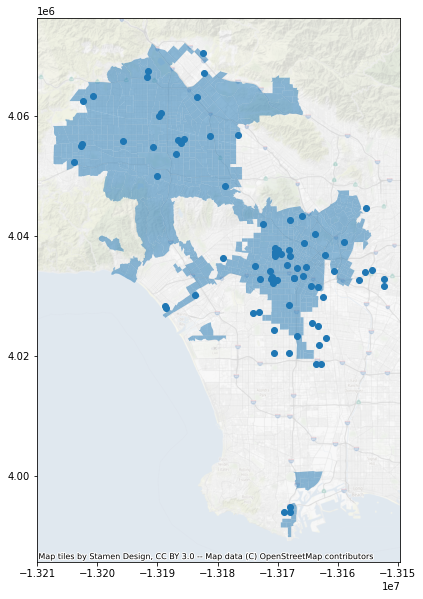

In [5]:
import matplotlib.pyplot as plt
import contextily as ctx

fig, ax = plt.subplots(figsize=(10,10))
pantrygdf.plot(ax=ax)
incomeDf.plot(ax=ax, alpha=0.5) # 50% opacity
ctx.add_basemap(ax=ax, zoom=12, alpha=0.3) # 30% opacity

Aha. If you recognize the shape of the city of Los Angeles, it looks like `cenpy` is not giving us all the tracts.

Let's troubleshoot. Our first stop will be the [documentation](https://cenpy-devs.github.io/cenpy/generated/cenpy.products.ACS.from_place.html).

There are a few things we could try:
* Provide the `place_type` argument as the docs recommend
* Experiment with the `strict_within` argument. Perhaps we are losing the tracts on the edge of the city boundary if this is `True` by default?
* Try a different census variable

In [ ]:
print(len(incomeDf))
incomeDf = products.ACS(2017).from_place('Los Angeles, CA', 
                                          place_type='Incorporated Place',
                                          level='tract', variables='B19019_001E')
print(len(incomeDf))

No, that didn't do it. We still get 749 tracts.

What about the `strict_within` argument?

In [6]:
incomeDf = products.ACS(2017).from_place('Los Angeles, CA', 
                                          place_type='Incorporated Place',
                                          level='tract', strict_within=False,
                                          variables='B19019_001E')
incomeDf.rename(columns={'B19019_001E':'median_HH_income'}, inplace=True)
print(len(incomeDf))

/opt/anaconda3/envs/uds/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Matched: Los Angeles, CA to Los Angeles city within layer Incorporated Places


/opt/anaconda3/envs/uds/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


1624


Aha. Fixed it. Now let's run our join again.

In [7]:
pantries_intersects = gpd.sjoin(incomeDf[['GEOID','geometry']], 
                           pantrygdf, how="inner", predicate='intersects')
print(len(pantries_intersects))

81


Now we are just missing one! Let's map it again to take a look. This is identical code to before.

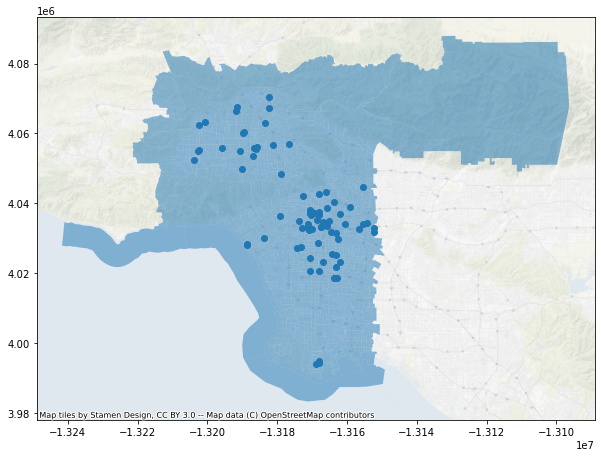

In [8]:
fig, ax = plt.subplots(figsize=(10,10))
pantrygdf.plot(ax=ax)
incomeDf.plot(ax=ax, alpha=0.5) # 50% opacity
ctx.add_basemap(ax=ax, zoom=12, alpha=0.3) # 30% opacity

It looks like two of them are just on the boundary. Let's adjust the axis limits to see if that's the case. That will zoom on the affected area.

We can set the limits by eyeballing from the figure above.

(4030000.0, 4040000.0)

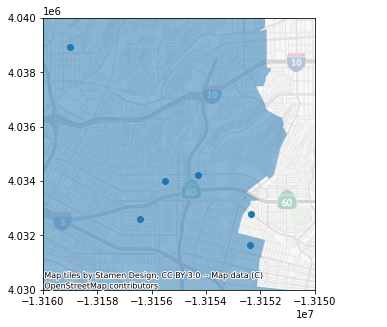

In [9]:
fig, ax = plt.subplots(figsize=(5,5))
pantrygdf.plot(ax=ax)
incomeDf.plot(ax=ax, alpha=0.5) # 50% opacity
ctx.add_basemap(ax=ax, zoom=12, alpha=0.3) # 30% opacity

ax.set_xlim([-1.316e7, -1.315e7])
ax.set_ylim([4.03e6, 4.04e6])

It looks like the geometry is imprecise, or perhaps the pantry is just outside of the city limits. Perhaps we could correct the coordinates manually, or ask `cenpy` for all tracts in LA County (not just the city).

The point here: spatial joins often throw up unexpected results. You'll have to do some detective work to figure out what goes wrong.

## Spatial attributes
We can access useful attributes of the geometry directly from `geopandas`. Areas, length, and bounding boxes are three examples.

Note that the units will be based on your projection. You probably don't want to measure distances or areas in degrees! But even a projection in meters can be distorted.

The best projection will vary locally. In the US, the State Plane coordinate systems are usually the best choice for local-level work. Los Angeles is in State Plane [California zone 5, which has an EPSG code of 3497](https://epsg.io/3497). Note the units are in meters. If you want feet, [try EPSG code 6424](https://epsg.io/6424). 

In [10]:
# in Web Mercator
print(incomeDf.geometry.area.head())

0    7.242145e+06
1    3.020178e+08
2    6.602881e+06
3    7.727567e+06
4    2.819700e+06
dtype: float64


In [11]:
# in State Plane
print(incomeDf.to_crs('EPSG:3497').geometry.area.head())

0    4.991983e+06
1    2.074825e+08
2    4.549752e+06
3    5.308387e+06
4    1.937493e+06
dtype: float64


For a polygon, length is the perimeter.

In [12]:
print(incomeDf.geometry.to_crs('EPSG:3497').length.head()) 

0    11881.853828
1    95028.641513
2    12475.924290
3    10451.050145
4     6870.749474
dtype: float64


The projection is less important for the bounding box, as long as you know which one you are using. Here, we are still in Web Mercator. But lat/lon is often the easiest to work with.

In [13]:
print(incomeDf.geometry.bounds.head())

          minx        miny         maxx        maxy
0 -13183928.75  3996735.05 -13180636.25  4000060.66
1 -13206496.55  3995106.41 -13179942.40  4033960.72
2 -13182761.01  3998547.12 -13178531.42  4001512.52
3 -13179813.38  4015632.36 -13177369.58  4019530.84
4 -13177861.17  4014658.55 -13176478.36  4017578.75


In [14]:
print(incomeDf.to_crs('EPSG:4326').geometry.bounds.head())

         minx       miny        maxx       maxy
0 -118.433247  33.760850 -118.403670  33.785683
1 -118.635977  33.748686 -118.397437  34.038410
2 -118.422757  33.774382 -118.384762  33.796522
3 -118.396278  33.901864 -118.374325  33.930926
4 -118.378741  33.894603 -118.366319  33.916375


## Distances and nearest neighbors
Another common use case is getting the distances between a geometry and a set of other geometries, or the nearest neighbor. Again, the projection is important here so let's convert to State Plane. 

In [15]:
pantrygdf.to_crs('EPSG:3497', inplace=True)
incomeDf.to_crs('EPSG:3497', inplace=True)

The nearest neighbor can be found with `sjoin_nearest`. The optional argument, `distance_col`, will add a column with the distances.

In [16]:
incomeDf.sjoin_nearest(pantrygdf, distance_col='dist_to_pantry')

NotImplementedError: Currently, only PyGEOS >= 0.10.0 supports `nearest_all`. To use PyGEOS within GeoPandas, you need to install PyGEOS: 'conda install pygeos' or 'pip install pygeos'

Note that we only have the result for the closest part of the census tract. If we want the centroid, we can create a new GeoDataFrame and convert its polygons to centroids.

<AxesSubplot:>

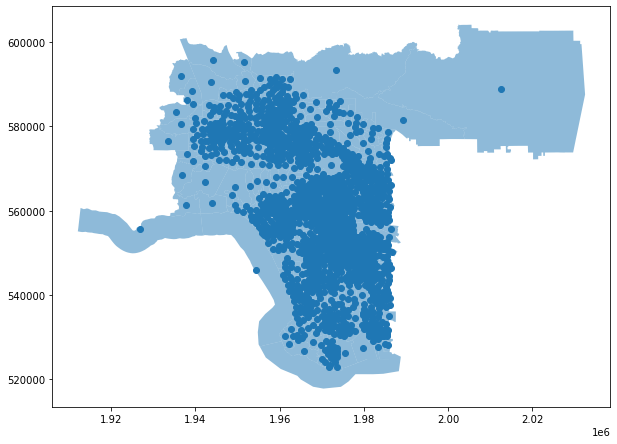

In [17]:
incomeDf_centroids = incomeDf.copy()
incomeDf_centroids.geometry = incomeDf.geometry.centroid

# map to show the centroids 
fig, ax=plt.subplots(figsize=(10,10))
incomeDf_centroids.plot(ax=ax)
incomeDf.plot(ax=ax, lw=4, alpha=0.5)

And let's do the nearest neighbor with these centroids.

In [18]:
incomeDf_centroids.sjoin_nearest(pantrygdf, distance_col='dist_to_pantry')

NotImplementedError: Currently, only PyGEOS >= 0.10.0 supports `nearest_all`. To use PyGEOS within GeoPandas, you need to install PyGEOS: 'conda install pygeos' or 'pip install pygeos'

Notice that the distances are a little larger than before.

In [26]:
incomeDf.sjoin_nearest(pantrygdf, 
distance_col='dist_to_pantry').dist_to_pantry.mean()

NotImplementedError: Currently, only PyGEOS >= 0.10.0 supports `nearest_all`. To use PyGEOS within GeoPandas, you need to install PyGEOS: 'conda install pygeos' or 'pip install pygeos'

In [20]:
incomeDf_centroids.sjoin_nearest(pantrygdf, 
        distance_col='dist_to_pantry').dist_to_pantry.mean()

NotImplementedError: Currently, only PyGEOS >= 0.10.0 supports `nearest_all`. To use PyGEOS within GeoPandas, you need to install PyGEOS: 'conda install pygeos' or 'pip install pygeos'

What if you don't just care about the closest one, but want to get the distances from a census tract to a larger number of pantries, or even all of them? For example, some accessibility measures look at the distance to the 2nd or 3rd closest destination (e.g. a grocery store), in order to capture the number of choices that people have.

To start with, let's look at the distances to a single tract. Note that `sort_values` will sort the results, so it's easiest to see the smallest and largest distances.

In [21]:
# take the first census tract, and get its geometry
tract = incomeDf.iloc[0].geometry

# get the distances from this tract to all the food pantries
distances = pantrygdf.distance(tract)
distances.sort_values(inplace=True)
distances

35    10049.809788
56    10712.376396
21    10858.990617
27    19241.583116
33    20245.141390
          ...     
32    54294.389929
6     55280.852664
11    55377.164123
71    56122.740145
68    58021.591671
Length: 82, dtype: float64

So how do we know which one is the 3rd closest? We can use `iloc` to get the 3rd row. 

In [22]:
distances.iloc[2]

10858.990617218229

If we want to calculate the distance to the 3rd closest pantry for each census tract, we can put this in a function.

The argument of the function will be the geometry of the tract. It will return the distance.

Once we have that function, we can use our old friend `apply` to apply it to every tract in the city of LA.

In [23]:
def get_3rd_closest_dist(geom):
    distances = pantrygdf.distance(geom)
    third_closest = distances.sort_values().iloc[2]
    return third_closest

incomeDf['dist_third_closest'] = incomeDf.geometry.apply(get_3rd_closest_dist)

In [24]:
incomeDf

,GEOID,geometry,median_HH_income,state,county,tract,dist_third_closest
0,06037670328,"POLYGON ((1959866.681 530558.767, 1959914.740 ...",177857.0,06,037,670328,10858.990617
1,06037990200,"POLYGON ((1941268.205 559259.978, 1941581.705 ...",NaN,06,037,990200,5146.897296
2,06037670326,"POLYGON ((1960889.161 531875.224, 1960955.969 ...",155000.0,06,037,670326,10075.220685
3,06037980013,"POLYGON ((1963358.760 547553.025, 1963358.827 ...",NaN,06,037,980013,7254.767133
4,06037602302,"POLYGON ((1964967.587 544294.950, 1964968.347 ...",126116.0,06,037,602302,7700.960256
...,...,...,...,...,...,...,...
1619,06037183103,"POLYGON ((1983200.844 568036.533, 1983201.411 ...",54271.0,06,037,183103,7167.414281
1620,06037531602,"POLYGON ((1984399.303 557216.014, 1984408.049 ...",31771.0,06,037,531602,1882.962564
1621,06037530301,"POLYGON ((1985243.186 558323.864, 1985269.302 ...",43092.0,06,037,530301,1103.447789
1622,06037533901,"POLYGON ((1984928.114 553118.298, 1984929.138 ...",45440.0,06,037,533901,5873.796249


Finally, let's plot using the `seaborn.regplot()` function that we saw before.

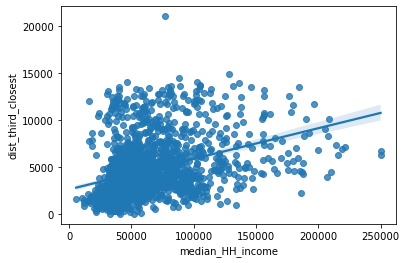

In [25]:
import seaborn as sns
ax = sns.regplot(x="median_HH_income", y="dist_third_closest", data=incomeDf)

<div class="alert alert-block alert-info">
<h3>Key Takeaways</h3>
<ul>
  <li>Intersects is the most common spatial predicate, but it's not always what you want.</li>
  <li>Areas, lengths, nearest neighbors, and distances are simple to calculate in geopandas.</li>
  <li>Use an an appropriate projection.</li>
  <li>As with any join, inspect your output. If it's not what you expect, computing summary statistics or mapping can help identify the problem.</li>
</ul>
</div>